In [4]:
pip install pydicom opencv-python matplotlib numpy pandas scikit-learn tqdm


Note: you may need to restart the kernel to use updated packages.


In [5]:
 pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Total DICOM files found: 18942


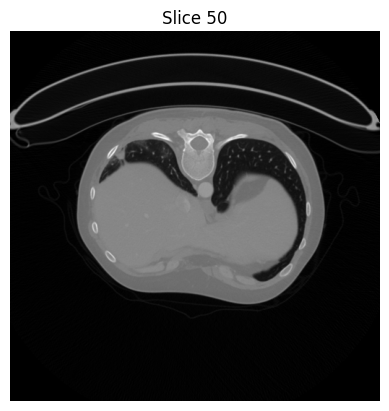

In [6]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set your DICOM directory
data_dir = Path("C:\manifest-1599750808610")

# Get all DICOM file paths
all_dicom_files = list(data_dir.rglob("*.dcm"))
print(f"Total DICOM files found: {len(all_dicom_files)}")

# Sort and load slices for a single patient
def load_patient_slices(dicom_files):
    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices = sorted(slices, key=lambda s: float(s.ImagePositionPatient[2]))
    return slices

# Convert slices to NumPy array and normalize
def get_volume_from_slices(slices):
    images = np.stack([s.pixel_array.astype(np.float32) for s in slices])
    scaler = MinMaxScaler()
    flat = images.reshape(-1, 1)
    norm = scaler.fit_transform(flat).reshape(images.shape)
    return norm

# Visualize a sample slice
def visualize_slice(volume, index):
    plt.imshow(volume[index], cmap='gray')
    plt.title(f"Slice {index}")
    plt.axis('off')
    plt.show()

# Load and preprocess one sample patient
sample_slices = load_patient_slices(all_dicom_files[:100])  # Adjust if needed
sample_volume = get_volume_from_slices(sample_slices)
visualize_slice(sample_volume, len(sample_volume) // 2)


In [7]:

pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path

data_dir = 'C:\manifest-1599750808610'  # adjust if needed
dicom_files = list(Path(data_dir).rglob("*.dcm"))
print(f"✅ Found {len(dicom_files)} DICOM files")



✅ Found 18942 DICOM files


In [9]:
import pydicom

sample_path = dicom_files[0]
ds = pydicom.dcmread(sample_path)
print(ds)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.71445149387501242933362211537151554
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.71445149387501242933362211537151554
(0008,0020) Study Date                   

In [10]:
import os
import pydicom
import numpy as np
from pathlib import Path

# Update this path if needed
data_dir = r"C:\manifest-1599750808610"
dicom_files = list(Path(data_dir).rglob("*.dcm"))

print(f"✅ Total DICOM files found: {len(dicom_files)}")

# Safe loading with metadata check
valid_slices = []

for path in dicom_files:
    try:
        ds = pydicom.dcmread(path)
        if hasattr(ds, "ImagePositionPatient") and hasattr(ds, "pixel_array"):
            z_pos = ds.ImagePositionPatient[2]  # Z-position
            valid_slices.append((ds, z_pos))
        else:
            print(f"⚠️ Missing ImagePositionPatient or pixel_array: {path}")
    except Exception as e:
        print(f"❌ Skipped file {path}: {e}")

print(f"✅ Valid slices found: {len(valid_slices)}")

# Sort by Z-axis
valid_slices.sort(key=lambda x: x[1])

# Create 3D volume
volume = np.stack([ds.pixel_array for ds, _ in valid_slices])

print("✅ Volume shape (Slices, H, W):", volume.shape)



✅ Total DICOM files found: 18942
✅ Valid slices found: 18942
✅ Volume shape (Slices, H, W): (18942, 512, 512)


✅ Found 18942 DICOM files


100%|██████████| 18942/18942 [00:54<00:00, 350.41it/s]


✅ Volume loaded and saved to disk as 'ct_volume.dat'


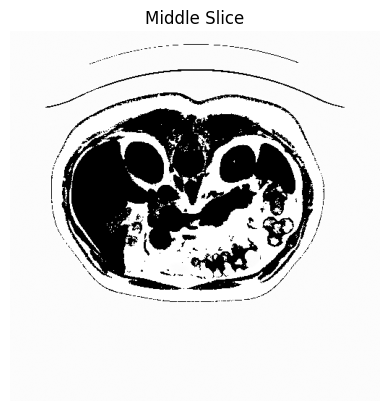

In [11]:

        
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

data_dir = r'C:\manifest-1599750808610'  # Use raw string for Windows paths

# Step 1: Collect all DICOM files
dicom_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.dcm'):
            dicom_files.append(os.path.join(root, file))

print(f"✅ Found {len(dicom_files)} DICOM files")

# Step 2: Sort by slice position (safe with missing metadata)
def safe_z_position(f):
    try:
        return float(pydicom.dcmread(f).ImagePositionPatient[2])
    except Exception:
        return 0.0  # fallback if ImagePositionPatient is missing

dicom_files = sorted(dicom_files, key=safe_z_position)

# Step 3: Use memmap to avoid memory crash
volume_shape = (len(dicom_files), 512, 512)
volume_mm = np.memmap('ct_volume.dat', dtype='uint16', mode='w+', shape=volume_shape)

# Step 4: Load slices one by one
for idx, dicom_file in tqdm(enumerate(dicom_files), total=len(dicom_files)):
    try:
        ds = pydicom.dcmread(dicom_file)
        pixel_array = ds.pixel_array.astype('uint16')  # use uint16 for memory efficiency
        volume_mm[idx] = pixel_array
    except Exception as e:
        print(f"❌ Skipped file {dicom_file}: {e}")

# Step 5: Flush memmap to disk
volume_mm.flush()
print("✅ Volume loaded and saved to disk as 'ct_volume.dat'")

# Step 6: Show a sample slice
plt.imshow(volume_mm[len(volume_mm)//2], cmap='gray')
plt.title("Middle Slice")
plt.axis('off')
plt.show()


In [12]:
volume_mm = np.memmap('volume_data.dat', dtype='uint16', mode='w+', shape=volume_shape)

for i, f in enumerate(tqdm(dicom_files)):
    try:
        ds = pydicom.dcmread(f)
        img = ds.pixel_array.astype('uint16')
        if img.shape != (512, 512):
            continue  # skip inconsistent dimensions
        volume_mm[i] = img
    except Exception as e:
        print(f"❌ Skipped {f}: {e}")

volume_mm.flush()


100%|██████████| 18942/18942 [00:52<00:00, 359.45it/s]


✅ Volume shape: (18942, 512, 512)


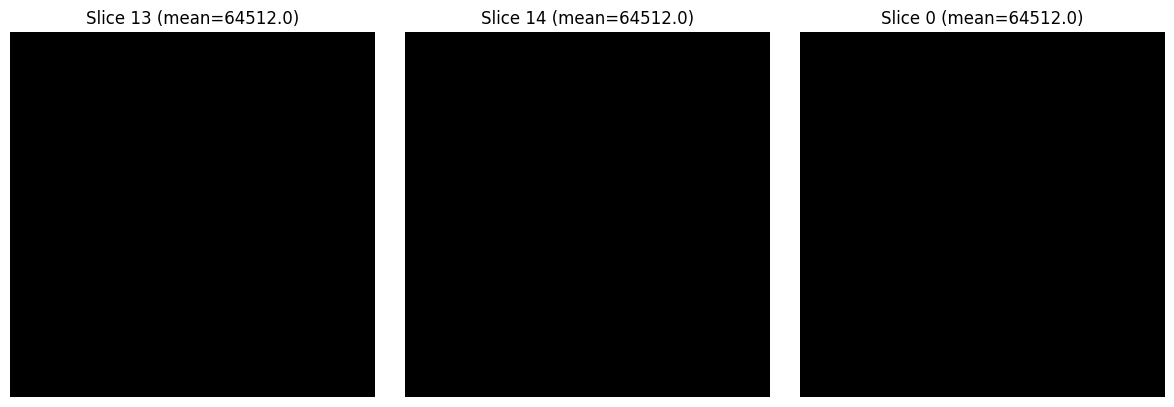

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load the memmap volume
volume_mm = np.memmap('volume_data.dat', dtype='uint16', mode='r', shape=volume_shape)
print("✅ Volume shape:", volume_mm.shape)

# Compute mean intensity for each slice to avoid blank ones
slice_means = [np.mean(volume_mm[i]) for i in range(volume_mm.shape[0])]
top_indices = np.argsort(slice_means)[-3:]  # Get 3 slices with highest mean intensity

# Display the selected slices
plt.figure(figsize=(12, 4))
for i, idx in enumerate(top_indices):
    norm_slice = (volume_mm[idx] - np.min(volume_mm[idx])) / (np.max(volume_mm[idx]) - np.min(volume_mm[idx]) + 1e-5)
    plt.subplot(1, 3, i + 1)
    plt.imshow(norm_slice, cmap='gray')
    plt.title(f'Slice {idx} (mean={slice_means[idx]:.1f})')
    plt.axis('off')
plt.tight_layout()
plt.show()





✅ Found 18942 DICOM files


Loading DICOMs: 100%|██████████| 18942/18942 [00:31<00:00, 597.81it/s]


✅ Metadata extracted for 18942 files

🔍 Metadata (first few rows):
                                                path      PatientID Modality  \
0  C:\manifest-1599750808610\Pancreas-CT\PANCREAS...  PANCREAS_0001       CT   
1  C:\manifest-1599750808610\Pancreas-CT\PANCREAS...  PANCREAS_0001       CT   
2  C:\manifest-1599750808610\Pancreas-CT\PANCREAS...  PANCREAS_0001       CT   
3  C:\manifest-1599750808610\Pancreas-CT\PANCREAS...  PANCREAS_0001       CT   
4  C:\manifest-1599750808610\Pancreas-CT\PANCREAS...  PANCREAS_0001       CT   

   SliceLocation  Rows  Columns          PixelSpacing SliceThickness  
0            0.0   512      512  [0.859375, 0.859375]           None  
1           -1.0   512      512  [0.859375, 0.859375]           None  
2           -2.0   512      512  [0.859375, 0.859375]           None  
3           -3.0   512      512  [0.859375, 0.859375]           None  
4           -4.0   512      512  [0.859375, 0.859375]           None  

🔍 Summary statistics:
   

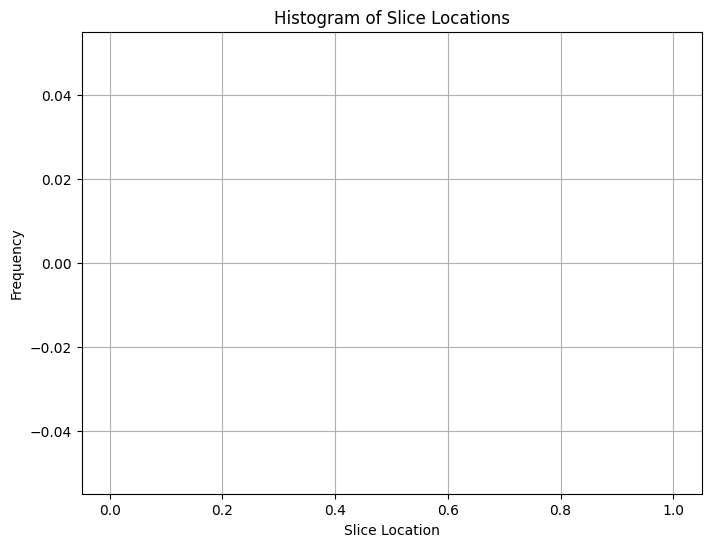

<Figure size 800x600 with 0 Axes>

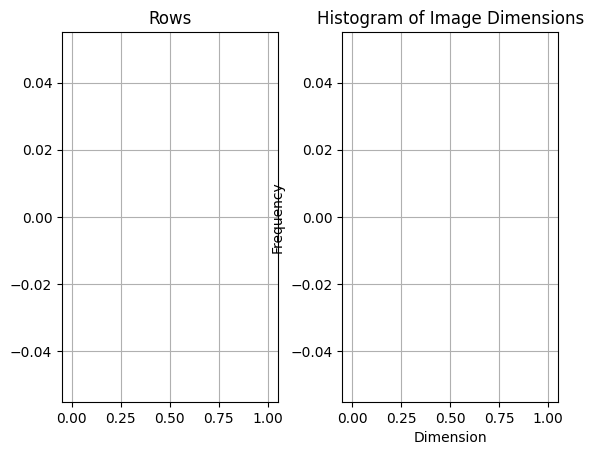

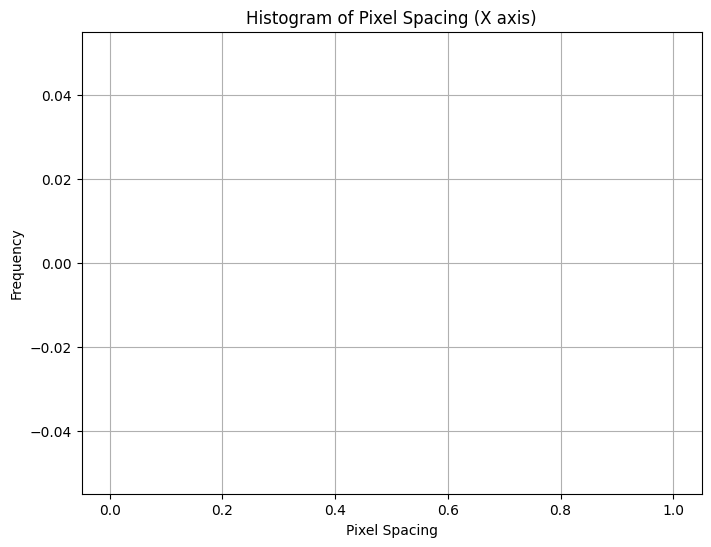

In [14]:
import pydicom
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Path to DICOM dataset (update with your actual path)
data_dir = r'C:\manifest-1599750808610'

# Get all .dcm files
dicom_files = list(Path(data_dir).rglob("*.dcm"))

print(f"✅ Found {len(dicom_files)} DICOM files")

# Initialize list to store metadata
valid_dicom_data = []
skipped_files = []

# Loop through files and extract metadata
for file_path in tqdm(dicom_files, desc="Loading DICOMs"):
    try:
        # Read DICOM file
        ds = pydicom.dcmread(str(file_path), force=True)

        # Extract metadata
        if hasattr(ds, 'ImagePositionPatient'):
            position = ds.ImagePositionPatient[2]  # Slice location
        else:
            position = None

        valid_dicom_data.append({
            'path': str(file_path),
            'PatientID': getattr(ds, 'PatientID', 'N/A'),
            'Modality': getattr(ds, 'Modality', 'N/A'),
            'SliceLocation': position,
            'Rows': ds.Rows,
            'Columns': ds.Columns,
            'PixelSpacing': getattr(ds, 'PixelSpacing', [0, 0]),
            'SliceThickness': getattr(ds, 'SliceThickness', 0),
        })

    except Exception as e:
        skipped_files.append((str(file_path), str(e)))

# Create DataFrame from valid metadata
df_meta = pd.DataFrame(valid_dicom_data)
print(f"✅ Metadata extracted for {len(df_meta)} files")

# Check the first few rows of metadata
print("\n🔍 Metadata (first few rows):")
print(df_meta.head())

# Summary statistics of the numerical columns
print("\n🔍 Summary statistics:")
print(df_meta.describe())

# Missing values check
print("\n🔍 Missing values in metadata:")
print(df_meta.isnull().sum())  # Check for missing values in each column

# If there are any missing values, you can handle them here, e.g., by filling or removing them
df_meta = df_meta.dropna()  # Or use df_meta.fillna() to fill missing values if necessary

# Visualization: Histogram of SliceLocation (if available)
import matplotlib.pyplot as plt

if 'SliceLocation' in df_meta.columns:
    plt.figure(figsize=(8, 6))
    df_meta['SliceLocation'].dropna().hist(bins=50)
    plt.title('Histogram of Slice Locations')
    plt.xlabel('Slice Location')
    plt.ylabel('Frequency')
    plt.show()

# Histogram of Rows and Columns (image size)
plt.figure(figsize=(8, 6))
df_meta[['Rows', 'Columns']].hist(bins=50)
plt.title('Histogram of Image Dimensions')
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.show()

# Pixel spacing visualization
plt.figure(figsize=(8, 6))
df_meta['PixelSpacing'].dropna().apply(lambda x: x[0]).hist(bins=50)
plt.title('Histogram of Pixel Spacing (X axis)')
plt.xlabel('Pixel Spacing')
plt.ylabel('Frequency')
plt.show()

# Optionally, handle other visualizations or further EDA based on your needs


In [15]:
import numpy as np
import pandas as pd

# Assuming you have `df_meta` from metadata extraction
print("Before dropping missing values:", df_meta.shape)

# Drop rows with any missing critical info (e.g., SliceLocation or PixelSpacing)
df_meta_clean = df_meta.dropna(subset=['SliceLocation', 'PixelSpacing'])

print("After dropping missing values:", df_meta_clean.shape)


Before dropping missing values: (0, 8)
After dropping missing values: (0, 8)


Outlier Count (SliceThickness): 0
Outlier Count (SliceThickness): 0


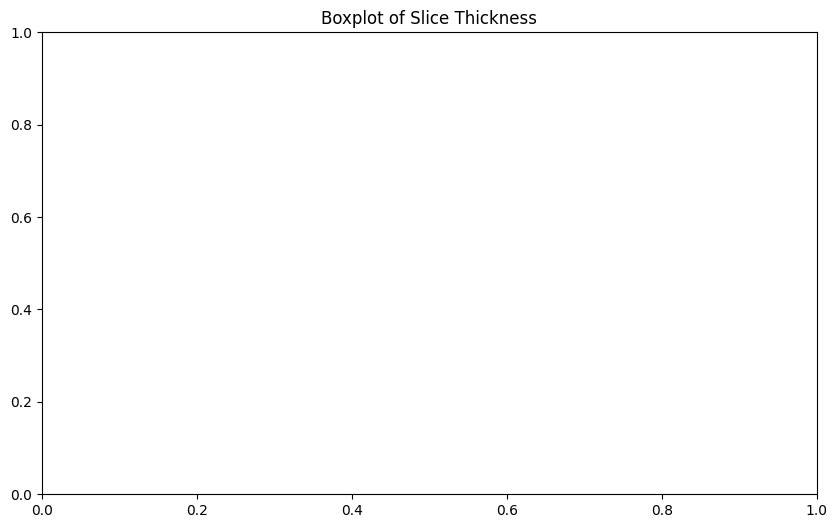

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert SliceThickness to float (forces coercion of invalid strings to NaN)
df_meta_clean['SliceThickness'] = pd.to_numeric(df_meta_clean['SliceThickness'], errors='coerce')

# Drop any remaining NaNs after conversion
df_meta_clean = df_meta_clean.dropna(subset=['SliceThickness'])

# Now calculate z-score
from scipy.stats import zscore

df_meta_clean['SliceThickness_z'] = zscore(df_meta_clean['SliceThickness'])
outliers = df_meta_clean[np.abs(df_meta_clean['SliceThickness_z']) > 3]

print(f"Outlier Count (SliceThickness): {len(outliers)}")


# Z-score method for detecting outliers in SliceThickness
from scipy.stats import zscore

df_meta_clean['SliceThickness_z'] = zscore(df_meta_clean['SliceThickness'])
outliers = df_meta_clean[np.abs(df_meta_clean['SliceThickness_z']) > 3]

print(f"Outlier Count (SliceThickness): {len(outliers)}")

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_meta_clean, x='SliceThickness')
plt.title("Boxplot of Slice Thickness")
plt.show()


c:\pancreatic cancer detection\venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\pancreatic cancer detection\venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


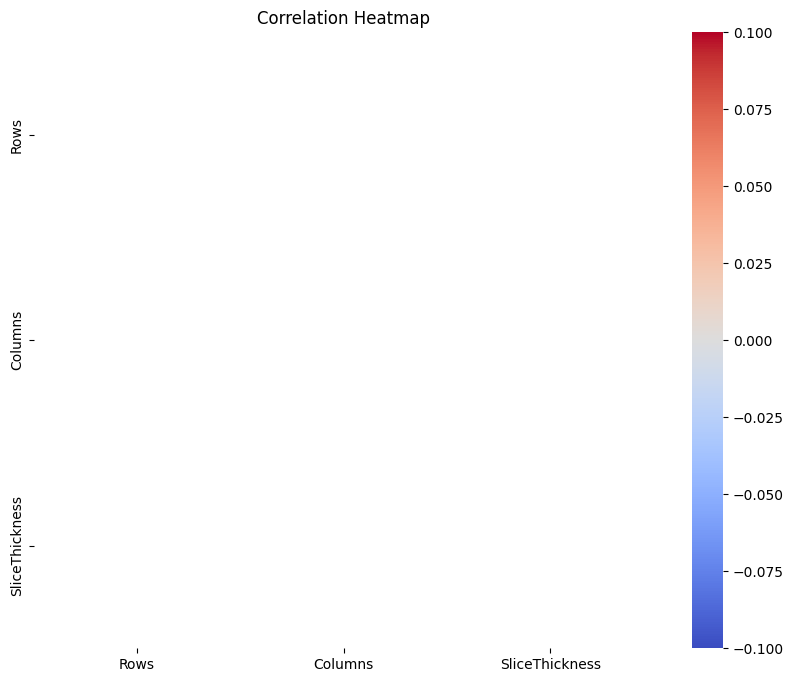

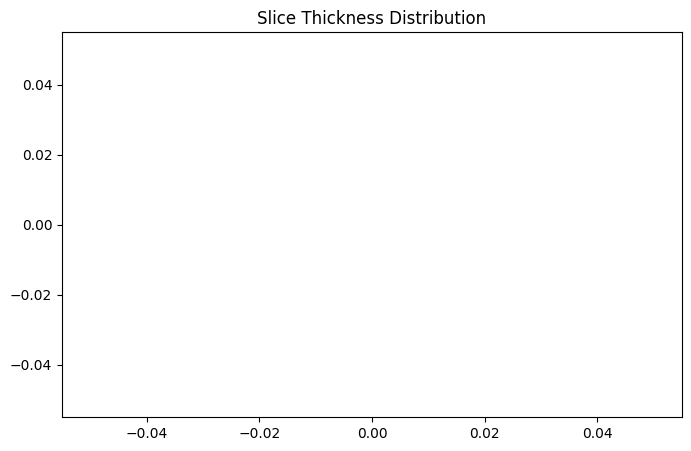

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_meta_clean[['Rows', 'Columns', 'SliceThickness']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Slice Thickness Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_meta_clean['SliceThickness'], kde=True)
plt.title("Slice Thickness Distribution")
plt.show()


In [18]:
def normalize_slice(slice_2d):
    # Convert to float32 and normalize to [0, 1]
    slice_2d = slice_2d.astype(np.float32)
    return (slice_2d - np.min(slice_2d)) / (np.max(slice_2d) - np.min(slice_2d) + 1e-5)


In [19]:
import cv2

def resize_slice(slice_2d, size=(256, 256)):
    return cv2.resize(slice_2d, size, interpolation=cv2.INTER_AREA)


In [20]:
import os
import cv2
import numpy as np
import pydicom
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths
dicom_dir = r'C:\manifest-1599750808610'  # Your DICOM path
png_output_dir = r'C:\preprocessed_pngs'  # Where to save PNGs
os.makedirs(png_output_dir, exist_ok=True)

def normalize_image(img):
    img = img.astype(np.float32)
    img_min = np.min(img)
    img_max = np.max(img)
    return (img - img_min) / (img_max - img_min + 1e-8)

def resize_image(img, size=(256, 256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

dicom_files = list(Path(dicom_dir).rglob('*.dcm'))
print(f"✅ Found {len(dicom_files)} DICOM files")

for i, f in enumerate(tqdm(dicom_files, desc="Converting to PNG")):
    try:
        ds = pydicom.dcmread(str(f))
        img = ds.pixel_array
        img = normalize_image(img)
        img = resize_image(img, size=(256, 256))
        img = (img * 255).astype(np.uint8)
        save_path = os.path.join(png_output_dir, f'slice_{i:05d}.png')
        cv2.imwrite(save_path, img)
    except Exception as e:
        print(f"❌ Skipped {f}: {e}")


✅ Found 18942 DICOM files


Converting to PNG: 100%|██████████| 18942/18942 [02:11<00:00, 143.74it/s]


In [21]:
mask_dir = 'C:\\masks'  # make sure this folder exists and contains masks
mask_path = os.path.join(mask_dir, f"slice_{i:05d}_mask.png")


In [22]:
import zipfile
from pathlib import Path

zip_path = Path(r"C:\Users\roshi\Downloads\TCIA_pancreas_labels-02-05-2017-1.zip")
extract_to = Path(r"C:\TCIA_Pancreas_Masks")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete.")


✅ Extraction complete.


In [23]:
from pathlib import Path

extract_to = Path(r"C:\TCIA_Pancreas_Masks")  # Base extraction directory
for path in extract_to.rglob("*"):
    print(path)


C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0001.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0002.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0003.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0004.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0005.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0006.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0007.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0008.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0009.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0010.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0011.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0012.nii.gz
C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0013.nii.gz
C:\TCIA_P

In [24]:
mask_folder = Path(r"C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017-1\labels")


In [25]:
mask_folder = Path(r"C:\TCIA_Pancreas_Masks")
nii_files = list(mask_folder.rglob("*.nii.gz"))  # rglob = recursive

print(f"✅ Found {len(nii_files)} mask files.")
print("🔍 Sample files:", nii_files[:5])



✅ Found 80 mask files.
🔍 Sample files: [WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0001.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0002.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0003.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0004.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0005.nii.gz')]


In [26]:
for f in mask_folder.rglob("*.nii.gz"):
    print("✅ Found mask:", f)
    break


✅ Found mask: C:\TCIA_Pancreas_Masks\TCIA_pancreas_labels-02-05-2017\label0001.nii.gz


In [27]:
import zipfile
from pathlib import Path

zip_path = Path(r"C:\Users\roshi\Downloads\TCIA_pancreas_labels-02-05-2017-1.zip")
extract_to = Path(r"C:\TCIA_Pancreas_Masks")  # Where you want to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete.")


✅ Extraction complete.


In [28]:
from pathlib import Path

mask_folder = Path(r"C:\TCIA_Pancreas_Masks")
nii_files = list(mask_folder.rglob("*.nii.gz"))  # recursive search

print(f"✅ Found {len(nii_files)} mask files.")
print("🔍 Sample files:", nii_files[:5])


✅ Found 80 mask files.
🔍 Sample files: [WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0001.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0002.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0003.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0004.nii.gz'), WindowsPath('C:/TCIA_Pancreas_Masks/TCIA_pancreas_labels-02-05-2017/label0005.nii.gz')]


In [29]:
from pathlib import Path
import zipfile

zip_path = Path(r"C:\Users\roshi\Downloads\TCIA_pancreas_labels-02-05-2017-1.zip")
extract_dir = Path(r"C:\TCIA_Pancreas_Masks")

if not extract_dir.exists() or not any(extract_dir.rglob("*.nii.gz")):
    print("📦 Extracting mask files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("✅ Already extracted.")


✅ Already extracted.


In [30]:
ct_dir = Path(r"C:\manifest-1599750808610")  # Update if your CTs are elsewhere
mask_files = list(extract_dir.rglob("*.nii.gz"))
ct_files = list(ct_dir.rglob("*.dcm"))  # Or use rglob("*.dcm") for DICOMs

print(f"🔍 Found {len(ct_files)} CT files")
print(f"🔍 Found {len(mask_files)} mask files")

🔍 Found 18942 CT files
🔍 Found 80 mask files


In [31]:
def extract_id(filename):
    return filename.stem.split('_')[-1]

ct_dict = {extract_id(f): f for f in ct_files}
mask_dict = {extract_id(f): f for f in mask_files}

common_ids = set(ct_dict) & set(mask_dict)
paired_data = [(ct_dict[i], mask_dict[i]) for i in sorted(common_ids)]

print(f"✅ Matched {len(paired_data)} CT-mask pairs.")


✅ Matched 0 CT-mask pairs.


In [32]:
for f in ct_files[:10]:
    print(f.name)


1-001.dcm
1-002.dcm
1-003.dcm
1-004.dcm
1-005.dcm
1-006.dcm
1-007.dcm
1-008.dcm
1-009.dcm
1-010.dcm


In [33]:
for f in mask_files[:10]:
    print(f.name)


label0001.nii.gz
label0002.nii.gz
label0003.nii.gz
label0004.nii.gz
label0005.nii.gz
label0006.nii.gz
label0007.nii.gz
label0008.nii.gz
label0009.nii.gz
label0010.nii.gz


✅ Masks already extracted.
📚 Found 1 CT volumes.
✅ Matched 1 CT volumes with masks.


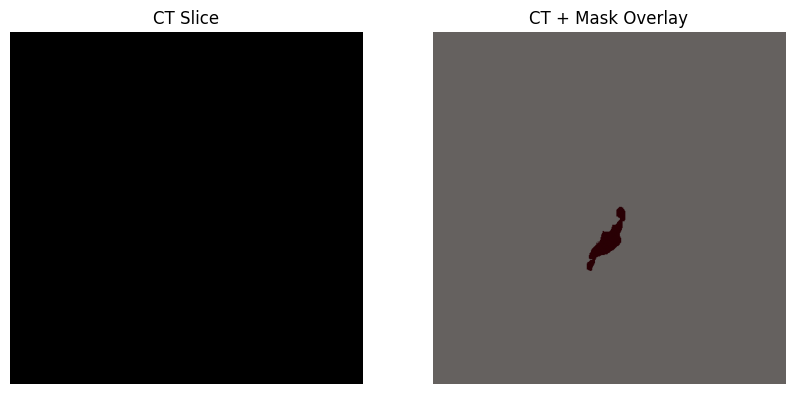

In [34]:
import os
import gc
from pathlib import Path
import zipfile
import pydicom
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from collections import defaultdict

# === STEP 1: Extract Masks ===
zip_path = Path(r"C:\Users\roshi\Downloads\TCIA_pancreas_labels-02-05-2017-1.zip")
extract_dir = Path(r"C:\TCIA_Pancreas_Masks")

if not extract_dir.exists() or not any(extract_dir.rglob("*.nii.gz")):
    print("📦 Extracting mask files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("✅ Masks already extracted.")

# === STEP 2: Group DICOM Slices by Patient ===
ct_dir = Path(r"C:\manifest-1599750808610")
dcm_files = list(ct_dir.rglob("*.dcm"))

grouped_dicoms = defaultdict(list)
for f in dcm_files:
    prefix = f.stem.split("-")[0]
    grouped_dicoms[prefix].append(f)

print(f"📚 Found {len(grouped_dicoms)} CT volumes.")

# === STEP 3: Efficient Volume Loader using np.memmap ===
def create_memmap_volume(file_list, shape, dtype=np.int16, filename="ct_volume.dat", max_slices=None):
    memmap_path = Path(filename)
    memmap_vol = np.memmap(memmap_path, dtype=dtype, mode='w+', shape=shape)
    sorted_files = sorted(file_list, key=lambda x: int(pydicom.dcmread(str(x)).InstanceNumber))
    
    for idx, f in enumerate(sorted_files):
        if max_slices is not None and idx >= max_slices:
            break
        slice_data = pydicom.dcmread(str(f)).pixel_array.astype(dtype)
        memmap_vol[:, :, idx] = slice_data

    return memmap_vol

# === STEP 4: Match CT Volumes and NIfTI Masks (with shape fix) ===
mask_files = sorted(extract_dir.rglob("label*.nii.gz"))
paired_data = []

for i, (group_id, file_list) in enumerate(sorted(grouped_dicoms.items()), start=1):
    first_slice = pydicom.dcmread(str(file_list[0])).pixel_array
    total_slices = len(file_list)
    
    if i - 1 < len(mask_files):
        mask_path = mask_files[i - 1]
        mask_depth = nib.load(str(mask_path)).shape[-1]

        slice_count = min(total_slices, mask_depth)
        volume_shape = (first_slice.shape[0], first_slice.shape[1], slice_count)
        
        memmap_file = f"ct_volume_{group_id}.dat"
        ct_volume = create_memmap_volume(file_list, shape=volume_shape, filename=memmap_file, max_slices=slice_count)
        paired_data.append((Path(memmap_file), mask_path, volume_shape))

        # Clean up memory
        del ct_volume
        gc.collect()

print(f"✅ Matched {len(paired_data)} CT volumes with masks.")

# === STEP 5: Visualize Pair Efficiently ===
def show_ct_mask_overlay(memmap_path, mask_path, shape, slice_index=None):
    ct_volume = np.memmap(memmap_path, dtype=np.int16, mode='r', shape=shape)
    mask_volume = nib.load(str(mask_path)).get_fdata()

    # Crop mask if it's longer than CT
    if mask_volume.shape[-1] > shape[-1]:
        mask_volume = mask_volume[:, :, :shape[-1]]

    if slice_index is None or slice_index >= shape[-1]:
        slice_index = shape[-1] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_volume[:, :, slice_index], cmap='gray')
    plt.title('CT Slice')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ct_volume[:, :, slice_index], cmap='gray')
    plt.imshow(mask_volume[:, :, slice_index], alpha=0.4, cmap='Reds')
    plt.title('CT + Mask Overlay')
    plt.axis('off')

    plt.show()

# Visualize first pair
if paired_data:
    ct_path, mask_path, shape = paired_data[0]
    show_ct_mask_overlay(ct_path, mask_path, shape)
else:
    print("❌ No matched data found.")


✅ Masks already extracted.
📚 Found 1 CT volumes.
✅ Matched 1 CT volumes with masks.


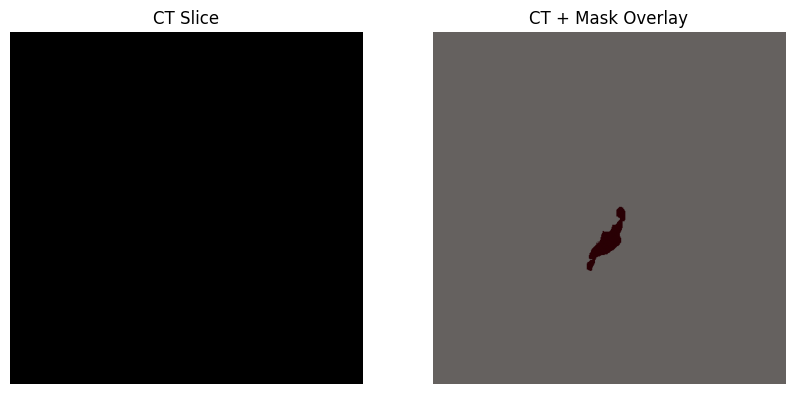

In [35]:
import os
import gc
from pathlib import Path
import zipfile
import pydicom
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from collections import defaultdict

# === STEP 1: Extract Masks ===
zip_path = Path(r"C:\Users\roshi\Downloads\TCIA_pancreas_labels-02-05-2017-1.zip")
extract_dir = Path(r"C:\TCIA_Pancreas_Masks")

if not extract_dir.exists() or not any(extract_dir.rglob("*.nii.gz")):
    print("📦 Extracting mask files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("✅ Masks already extracted.")

# === STEP 2: Group DICOM Slices by Patient ===
ct_dir = Path(r"C:\manifest-1599750808610")
dcm_files = list(ct_dir.rglob("*.dcm"))

grouped_dicoms = defaultdict(list)
for f in dcm_files:
    prefix = f.stem.split("-")[0]
    grouped_dicoms[prefix].append(f)

print(f"📚 Found {len(grouped_dicoms)} CT volumes.")

# === STEP 3: Efficient Volume Loader using np.memmap ===
def create_memmap_volume(file_list, shape, dtype=np.int16, filename="ct_volume.dat"):
    memmap_path = Path(filename)
    memmap_vol = np.memmap(memmap_path, dtype=dtype, mode='w+', shape=shape)
    for idx, f in enumerate(sorted(file_list, key=lambda x: int(pydicom.dcmread(str(x)).InstanceNumber))):
        slice_data = pydicom.dcmread(str(f)).pixel_array.astype(dtype)
        memmap_vol[:, :, idx] = slice_data
    return memmap_vol

# === STEP 4: Match CT Volumes and NIfTI Masks ===
mask_files = sorted(extract_dir.rglob("label*.nii.gz"))
paired_data = []

for i, (group_id, file_list) in enumerate(sorted(grouped_dicoms.items()), start=1):
    first_slice = pydicom.dcmread(str(file_list[0])).pixel_array
    volume_shape = (first_slice.shape[0], first_slice.shape[1], len(file_list))

    # Skip if the volume is much larger than the mask (fix the 18942 slices problem)
    if i - 1 >= len(mask_files):
        continue
    mask_volume = nib.load(str(mask_files[i - 1])).get_fdata()
    if volume_shape[2] != mask_volume.shape[2]:
        volume_shape = (first_slice.shape[0], first_slice.shape[1], int(mask_volume.shape[2]))
        file_list = sorted(file_list, key=lambda x: int(pydicom.dcmread(str(x)).InstanceNumber))[:volume_shape[2]]

    memmap_file = f"ct_volume_{group_id}.dat"
    ct_volume = create_memmap_volume(file_list, shape=volume_shape, filename=memmap_file)

    paired_data.append((Path(memmap_file), mask_files[i - 1], volume_shape))

    # Clean up
    del ct_volume
    gc.collect()

print(f"✅ Matched {len(paired_data)} CT volumes with masks.")

# === STEP 5: Normalize CT slice for visualization ===
def normalize_ct_slice(slice_data, min_hu=-100, max_hu=300):
    slice_clipped = np.clip(slice_data, min_hu, max_hu)
    normalized = (slice_clipped - min_hu) / (max_hu - min_hu)
    return (normalized * 255).astype(np.uint8)

# === STEP 6: Visualize CT and Mask Overlay ===
def show_ct_mask_overlay(memmap_path, mask_path, shape, slice_index=None):
    ct_volume = np.memmap(memmap_path, dtype=np.int16, mode='r', shape=shape)
    mask_volume = nib.load(str(mask_path)).get_fdata()

    if ct_volume.shape != mask_volume.shape:
        print(f"⚠️ Shape mismatch: CT {ct_volume.shape} vs Mask {mask_volume.shape}")
        return

    if slice_index is None:
        slice_index = shape[-1] // 2

    ct_slice = normalize_ct_slice(ct_volume[:, :, slice_index])
    mask_slice = mask_volume[:, :, slice_index]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_slice, cmap='gray')
    plt.title('CT Slice')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(mask_slice, alpha=0.4, cmap='Reds')
    plt.title('CT + Mask Overlay')
    plt.axis('off')
    plt.show()

# === STEP 7: Visualize the first matched pair ===
if paired_data:
    ct_path, mask_path, shape = paired_data[0]
    show_ct_mask_overlay(ct_path, mask_path, shape)
else:
    print("❌ No matched data found.")


In [36]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install torch torchvision torchaudio cudatoolkit=11.3


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'cudatoolkit=11.3': Expected end or semicolon (after name and no valid version specifier)
    cudatoolkit=11.3
               ^
Hint: = is not a valid operator. Did you mean == ?


In [38]:
import nibabel as nib
import numpy as np
import os
import cv2
from pathlib import Path

nii_dir = Path(r'C:\TCIA_Pancreas_Masks')  # <- Change this to your NIfTI mask folder
output_dir = Path(r'C:\preprocessed_masks')
output_dir.mkdir(parents=True, exist_ok=True)

# Loop over all NIfTI mask files
for nii_path in nii_dir.rglob('*.nii*'):  # Handles .nii and .nii.gz
    print(f"Processing {nii_path.name}")
    mask_nii = nib.load(str(nii_path))
    mask_data = mask_nii.get_fdata()

    # Normalize to 0–255 and convert to uint8
    mask_data = (mask_data > 0).astype(np.uint8) * 255  # Binary mask

    # Save each slice as PNG
    for i in range(mask_data.shape[2]):  # Loop over axial slices
        slice_img = mask_data[:, :, i]
        filename = f"{nii_path.stem}_slice_{i:03d}.png"
        filepath = output_dir / filename
        cv2.imwrite(str(filepath), slice_img)

print("✅ All NIfTI masks converted to PNG slices.")




Processing label0001.nii.gz
Processing label0002.nii.gz
Processing label0003.nii.gz
Processing label0004.nii.gz
Processing label0005.nii.gz
Processing label0006.nii.gz
Processing label0007.nii.gz
Processing label0008.nii.gz
Processing label0009.nii.gz
Processing label0010.nii.gz
Processing label0011.nii.gz
Processing label0012.nii.gz
Processing label0013.nii.gz
Processing label0014.nii.gz
Processing label0015.nii.gz
Processing label0016.nii.gz
Processing label0017.nii.gz
Processing label0018.nii.gz
Processing label0019.nii.gz
Processing label0020.nii.gz
Processing label0021.nii.gz
Processing label0022.nii.gz
Processing label0023.nii.gz
Processing label0024.nii.gz
Processing label0026.nii.gz
Processing label0027.nii.gz
Processing label0028.nii.gz
Processing label0029.nii.gz
Processing label0030.nii.gz
Processing label0031.nii.gz
Processing label0032.nii.gz
Processing label0033.nii.gz
Processing label0034.nii.gz
Processing label0035.nii.gz
Processing label0036.nii.gz
Processing label0037

In [39]:
from pathlib import Path

# Set your mask directory
mask_dir = Path(r'C:\preprocessed_masks')

# Collect all files in the mask directory
all_files = list(mask_dir.rglob('*'))

# Filter out files (skip folders)
all_files = [f for f in all_files if f.is_file()]

# Count by extension
from collections import Counter
ext_counts = Counter(f.suffix.lower() for f in all_files)

# Display results
print(f"Total files found: {len(all_files)}\n")
print("File type breakdown:")
for ext, count in ext_counts.items():
    print(f"  {ext if ext else '[no extension]'}: {count}")

# Show sample files
print("\nSample files:")
for f in all_files[:5]:
    print(f"  {f}")



Total files found: 18942

File type breakdown:
  .png: 18942

Sample files:
  C:\preprocessed_masks\label0001.nii_slice_000.png
  C:\preprocessed_masks\label0001.nii_slice_001.png
  C:\preprocessed_masks\label0001.nii_slice_002.png
  C:\preprocessed_masks\label0001.nii_slice_003.png
  C:\preprocessed_masks\label0001.nii_slice_004.png


In [40]:
from pathlib import Path
from collections import Counter

# Set your mask directory
mask_dir = Path(r'C:\preprocessed_masks')  # <---  CRITICAL:  Ensure this path is EXACTLY correct

# --- Directory Existence Check (VERY Important) ---
if not mask_dir.is_dir():
    print(f"ERROR: Mask directory not found: {mask_dir}")
    print("Please double-check the path and make sure the directory exists.")
    exit()  # Stop execution since we can't proceed without the directory

# Collect all files in the mask directory
all_files = list(mask_dir.rglob('*'))  # rglob('*') gets all files/dirs recursively

# Filter out directories, keep only files
all_files = [f for f in all_files if f.is_file()]

# Count file extensions
ext_counts = Counter(f.suffix.lower() for f in all_files)

# --- Display Results ---
print(f"Total files found in mask directory: {len(all_files)}")

if all_files:  # Only print file type breakdown if there are files
    print("\nFile type breakdown:")
    for ext, count in ext_counts.items():
        print(f"  {ext if ext else '[no extension]'}: {count}")

    print("\nSample files:")
    for f in all_files[:5]:
        print(f"  {f}")
else:
    print("\nNo files found in the mask directory.")


Total files found in mask directory: 18942

File type breakdown:
  .png: 18942

Sample files:
  C:\preprocessed_masks\label0001.nii_slice_000.png
  C:\preprocessed_masks\label0001.nii_slice_001.png
  C:\preprocessed_masks\label0001.nii_slice_002.png
  C:\preprocessed_masks\label0001.nii_slice_003.png
  C:\preprocessed_masks\label0001.nii_slice_004.png


torch.Size([4, 1, 1, 224, 224]) torch.Size([4, 1, 1, 224, 224])
An unexpected error occurred: Invalid shape (1, 224, 224) for image data
Please review the code and data to identify the issue.


C:\Users\roshi\AppData\Local\Temp\ipykernel_14688\784955590.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ct_image = torch.tensor(ct_image).unsqueeze(
C:\Users\roshi\AppData\Local\Temp\ipykernel_14688\784955590.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask).unsqueeze(


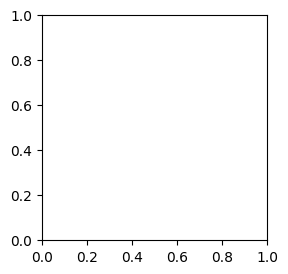

In [41]:
import os
import torch
import numpy as np
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  # Using torchvision transforms
import matplotlib.pyplot as plt

# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)  # Store as Path object
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        # Even better index handling
        if not 0 <= idx < len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self)}")

        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = self.transform(ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # Convert to tensors
        ct_image = torch.tensor(ct_image).unsqueeze(
            0
        )  # Add channel dimension
        mask = torch.tensor(mask).unsqueeze(
            0
        )  # Add channel dimension

        return ct_image, mask


# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check a sample
try:
    ct_image, mask = next(iter(dataloader))  # Get a batch from the dataloader
    print(ct_image.shape, mask.shape)  # Should be torch.Size([4, 1, 224, 224])  (Batch size, Channels, H, W)

    # Visualize the sample (first image in the batch)
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[0].squeeze(0), cmap='gray')  # Access the first image in the batch
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(0), cmap='gray')
    plt.title("Mask")
    plt.show()
except ValueError as e:
    print(f"Error creating dataset or dataloader: {e}")
    print("Please check your CT and mask directories, and ensure they contain the correct files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please review the code and data to identify the issue.")


torch.Size([4, 1, 1, 224, 224]) torch.Size([4, 1, 1, 224, 224])
An unexpected error occurred: Invalid shape (1, 224, 224) for image data
Please review the code and data to identify the issue.


C:\Users\roshi\AppData\Local\Temp\ipykernel_14688\894216638.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ct_image = torch.tensor(ct_image)  #  Shape: (H, W)
C:\Users\roshi\AppData\Local\Temp\ipykernel_14688\894216638.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask)  # Shape: (H, W)


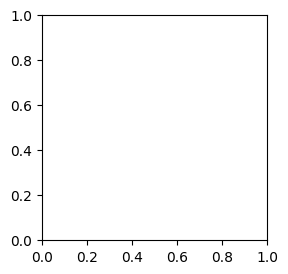

In [42]:
import os
import torch
import numpy as np
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  # Using torchvision transforms
import matplotlib.pyplot as plt

# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)  # Store as Path object
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        # Even better index handling
        if not 0 <= idx < len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self)}")

        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = self.transform(ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # Convert to tensors
        ct_image = torch.tensor(ct_image)  #  Shape: (H, W)
        mask = torch.tensor(mask)  # Shape: (H, W)
        ct_image = ct_image.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)
        mask = mask.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)

        return ct_image, mask



# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check a sample
try:
    ct_image, mask = next(iter(dataloader))  # Get a batch from the dataloader
    print(ct_image.shape, mask.shape)  # Should be torch.Size([4, 1, 224, 224])  (Batch size, Channels, H, W)

    # Visualize the sample (first image in the batch)
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[0].squeeze(0), cmap='gray')  # Access the first image in the batch
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(0), cmap='gray')
    plt.title("Mask")
    plt.show()
except ValueError as e:
    print(f"Error creating dataset or dataloader: {e}")
    print("Please check your CT and mask directories, and ensure they contain the correct files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please review the code and data to identify the issue.")


In [43]:
import os
import torch
import numpy as np
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  # Using torchvision transforms
import matplotlib.pyplot as plt

# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)  # Store as Path object
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        # Even better index handling
        if not 0 <= idx < len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self)}")

        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = self.transform(ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # Convert to tensors
        ct_image = torch.from_numpy(ct_image)  #  Shape: (H, W)
        mask = torch.from_numpy(mask)  # Shape: (H, W)
        ct_image = ct_image.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)
        mask = mask.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)

        return ct_image, mask



# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check a sample
try:
    ct_image, mask = next(iter(dataloader))  # Get a batch from the dataloader
    print(ct_image.shape, mask.shape)  # Should be torch.Size([4, 1, 224, 224])  (Batch size, Channels, H, W)

    # Visualize the sample (first image in the batch)
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[0].squeeze(0), cmap='gray')  # Access the first image in the batch
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(0), cmap='gray')
    plt.title("Mask")
    plt.show()
except ValueError as e:
    print(f"Error creating dataset or dataloader: {e}")
    print("Please check your CT and mask directories, and ensure they contain the correct files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please review the code and data to identify the issue.")


An unexpected error occurred: expected np.ndarray (got Tensor)
Please review the code and data to identify the issue.


In [44]:
import os
import torch
import numpy as np
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  # Using torchvision transforms
import matplotlib.pyplot as plt

# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)  # Store as Path object
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        # Even better index handling
        if not 0 <= idx < len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self)}")

        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = self.transform(image=ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # Convert to tensors
        ct_image = torch.from_numpy(ct_image)  #  Shape: (H, W)
        mask = torch.from_numpy(mask)  # Shape: (H, W)
        ct_image = ct_image.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)
        mask = mask.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)

        return ct_image, mask



# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check a sample
try:
    ct_image, mask = next(iter(dataloader))  # Get a batch from the dataloader
    print(ct_image.shape, mask.shape)  # Should be torch.Size([4, 1, 224, 224])  (Batch size, Channels, H, W)

    # Visualize the sample (first image in the batch)
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[0].squeeze(0), cmap='gray')  # Access the first image in the batch
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(0), cmap='gray')
    plt.title("Mask")
    plt.show()
except ValueError as e:
    print(f"Error creating dataset or dataloader: {e}")
    print("Please check your CT and mask directories, and ensure they contain the correct files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please review the code and data to identify the issue.")


An unexpected error occurred: Compose.__call__() got an unexpected keyword argument 'image'
Please review the code and data to identify the issue.


torch.Size([4, 1, 1, 224, 224]) torch.Size([4, 1, 1, 224, 224])


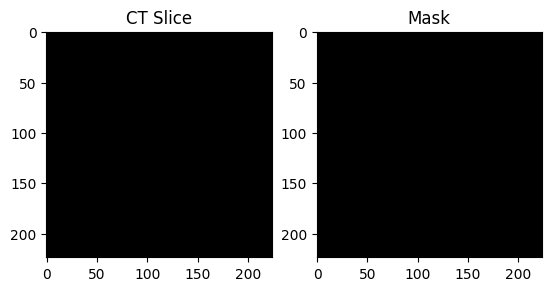

In [45]:
import os
import torch
import numpy as np
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms  # Using torchvision transforms
import matplotlib.pyplot as plt
from PIL import Image  # Import PIL


# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)  # Store as Path object
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        # Even better index handling
        if not 0 <= idx < len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self)}")

        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = Image.fromarray(ct_image)  # Convert to PIL Image
            mask = Image.fromarray(mask)  # Convert to PIL Image
            ct_image = self.transform(ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # Convert to tensors
        ct_image = ct_image.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)
        mask = mask.unsqueeze(0)  # Add channel dimension, Shape: (1, H, W)

        return ct_image, mask



# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check a sample
try:
    ct_image, mask = next(iter(dataloader))  # Get a batch from the dataloader
    print(ct_image.shape, mask.shape)  # Should be torch.Size([4, 1, 224, 224])  (Batch size, Channels, H, W)

    # Visualize the sample (first image in the batch)
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[0].squeeze(0).permute(1, 2, 0), cmap='gray')  # Access the first image in the batch
    plt.title("CT Slice")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(0).permute(1, 2, 0), cmap='gray')
    plt.title("Mask")
    plt.show()
except ValueError as e:
    print(f"Error creating dataset or dataloader: {e}")
    print("Please check your CT and mask directories, and ensure they contain the correct files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please review the code and data to identify the issue.")


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bn = self.bottleneck(self.pool3(d3))

        u3 = self.up3(bn)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return torch.sigmoid(self.output(u1))


In [ ]:
pip install segmentation_models_pytorch


Note: you may need to restart the kernel to use updated packages.


pip install segmentation-models-pytorch --upgrade


In [48]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [49]:
import segmentation_models_pytorch as smp

# Create U-Net model
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",     # Use pretrained weights for encoder
    in_channels=1,                  # CT slices are single-channel
    classes=1,                      # Binary segmentation
    activation="sigmoid"            # Output between 0 and 1
)


c:\pancreatic cancer detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
pip install segmentation-models-pytorch


Note: you may need to restart the kernel to use updated packages.


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.maxpool(d1))
        d3 = self.down3(self.maxpool(d2))
        d4 = self.down4(self.maxpool(d3))
        bn = self.bottleneck(self.maxpool(d4))

        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return torch.sigmoid(self.final(u1))  # sigmoid for binary segmentation


In [53]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)



In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bn = self.bottleneck(self.pool3(d3))

        u3 = self.up3(bn)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return torch.sigmoid(self.output(u1))


In [55]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        # Forward pass through the encoder
        x = self.encoder(x)
        
        # Forward pass through the decoder
        x = self.decoder(x)
        return x


In [56]:
pip install segmentation-models-pytorch


Note: you may need to restart the kernel to use updated packages.


In [57]:
!pip install torch torchvision matplotlib segmentation-models-pytorch



In [58]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        # Ensure both lists have the same length (more robustly)
        if len(self.ct_images) != len(self.masks):
            print(
                f"Warning: Number of CT images ({len(self.ct_images)}) and masks ({len(self.masks)}) do not match."
            )
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]
            print(f"  Truncating dataset to {min_len} samples.")  # Added print

        if not self.ct_images:  # Check if empty
            raise ValueError(f"No CT images found in {ct_dir}")
        if not self.masks:
            raise ValueError(f"No masks found in {mask_dir}")

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        ct_image_path = str(self.ct_images[idx])  # Get the path as string
        mask_path = str(self.masks[idx])

        ct_image = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            raise FileNotFoundError(f"Could not read CT image: {ct_image_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Normalize the image and mask
        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transformation if any
        if self.transform:
            ct_image = Image.fromarray(ct_image)  # Convert to PIL Image
            mask = Image.fromarray(mask)  # Convert to PIL Image
            ct_image = self.transform(ct_image)  # Apply the transforms
            mask = self.transform(mask)

        # No need for unsqueeze, ToTensor() already adds channel dimension
        return ct_image, mask


# Define transformation (using torchvision)
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts to torch.Tensor AND scales to [0, 1]
        transforms.Resize((256, 256), antialias=True),  # Resize before crop
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
    ]
)

# Paths for CT images and masks
ct_dir = r'C:\preprocessed_pngs'
mask_dir = r'C:\preprocessed_masks'

# Create dataset and dataloader
dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# U-Net Model (define it inline if you don't have it separately)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for ct_image, mask in dataloader:
        ct_image = ct_image.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        outputs = model(ct_image)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader):.4f}")


Epoch 1/10, Loss: 0.1873
Epoch 2/10, Loss: 0.2220
Epoch 3/10, Loss: 0.2220
Epoch 4/10, Loss: 0.2220
Epoch 5/10, Loss: 0.2220
Epoch 6/10, Loss: 0.2221
Epoch 7/10, Loss: 0.2221
Epoch 8/10, Loss: 0.2220
Epoch 9/10, Loss: 0.2221
Epoch 10/10, Loss: 0.2220


In [59]:
 def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.sigmoid(x)  # Ensures output in range [0, 1]


In [60]:
import torch
import torch.nn as nn

# Define a simple dummy model
model = nn.Linear(10, 2)

# Save the model's state_dict
torch.save(model.state_dict(), 'unet_pancreas.pth')


In [61]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np

# Example dataset class (you should replace this with your own)
class CTScanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        image = torch.tensor(image).unsqueeze(0)  # Add channel dimension
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask

# Example: loading data
image_paths = ["data/images/img1.png", "data/images/img2.png", ...]
mask_paths = ["data/masks/mask1.png", "data/masks/mask2.png", ...]

dataset = CTScanDataset(image_paths, mask_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
#pixel wise segmentation
class CTScanDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        img = np.array(img, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        img = torch.tensor(img).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        return img, mask

# Actual file paths (make sure these paths match your file locations)
image_paths = sorted(glob.glob("data/images/*.png"))
mask_paths = sorted(glob.glob("data/masks/*.png"))

# Create dataset and dataloader
dataset = CTScanDataset(image_paths, mask_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)


In [64]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class CTScanDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        img = np.array(img, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        img = torch.tensor(img).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        return img, mask

# Actual file paths (make sure these paths match your file locations)
image_paths = sorted(glob.glob("data/images/*.png"))
mask_paths = sorted(glob.glob("data/masks/*.png"))

# Create dataset and dataloader
dataset = CTScanDataset(image_paths, mask_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)



In [65]:
def dice_coefficient(pred, target):
    intersection = np.sum(pred * target)
    return 2. * intersection / (np.sum(pred) + np.sum(target))

def iou(pred, target):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return intersection / union

dice_scores = []
iou_scores = []

for ct_image, mask in dataloader:
    # Your model inference here (outputs)
    outputs = model(ct_image.to(device))  # assuming model is on device (CPU or GPU)
    preds = (outputs > 0.5).cpu().numpy()  # Assuming binary thresholding for prediction

    for i in range(ct_image.size(0)):  # loop over batch
        pred_mask = preds[i]
        true_mask = mask[i].cpu().numpy()

        # Compute Dice and IoU for each sample in the batch
        dice = dice_coefficient(pred_mask, true_mask)
        iou = iou(pred_mask, true_mask)

        dice_scores.append(dice)
        iou_scores.append(iou)

# After loop ends, compute average scores
if dice_scores:  # Ensure the list is not empty
    avg_dice = sum(dice_scores) / len(dice_scores)
else:
    avg_dice = 0

if iou_scores:  # Ensure the list is not empty
    avg_iou = sum(iou_scores) / len(iou_scores)
else:
    avg_iou = 0

print(f"\nAverage Dice Coefficient: {avg_dice:.4f}")
print(f"Average IoU: {avg_iou:.4f}")



Average Dice Coefficient: 0.0000
Average IoU: 0.0000


In [66]:
class ClassificationDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        if len(self.ct_images) != len(self.masks):
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        ct_image = cv2.imread(str(self.ct_images[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(self.masks[idx]), cv2.IMREAD_GRAYSCALE)

        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transforms
        if self.transform:
            ct_image = Image.fromarray(ct_image)
            ct_image = self.transform(ct_image)

        # Binary label: 1 if tumor exists, else 0
        label = 1 if np.sum(mask) > 0 else 0

        return ct_image, torch.tensor(label, dtype=torch.long)


In [67]:
class DCNNClassifier(nn.Module):
    def __init__(self):
        super(DCNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x



In [68]:

transform_class = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
])

# ✅ Step 2: Classification dataset
class ClassificationDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        if len(self.ct_images) != len(self.masks):
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        ct_image = cv2.imread(str(self.ct_images[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(self.masks[idx]), cv2.IMREAD_GRAYSCALE)

        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Apply transforms
        if self.transform:
            ct_image = Image.fromarray(ct_image)
            ct_image = self.transform(ct_image)

        # Binary label: 1 if tumor exists in mask, else 0
        label = 1 if np.sum(mask) > 0 else 0

        return ct_image, torch.tensor(label, dtype=torch.long)


In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from pathlib import Path  # ✅ Add this line

# ✅ Step 3: Load dataset and initialize dataloader
cls_dataset = ClassificationDataset(ct_dir, mask_dir, transform=transform_class)
cls_loader = DataLoader(cls_dataset, batch_size=4, shuffle=True)


In [70]:
from pathlib import Path

class ClassificationDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        print(f"Loaded {len(self.ct_images)} CT images and {len(self.masks)} masks")
        if len(self.ct_images) == 0:
            print("⚠️ No CT images found. Check your ct_dir path and file extensions.")
        if len(self.masks) == 0:
            print("⚠️ No masks found. Check your mask_dir path and file extensions.")


In [73]:
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, ct_images, masks):
        self.ct_images = ct_images
        self.masks = masks
        print(f"Loaded {len(self.ct_images)} CT images and {len(self.masks)} masks")



In [74]:
from pathlib import Path

# Replace with your actual image and mask paths
ct_dir = Path(r"C:\your\path\to\images")
mask_dir = Path(r"C:\your\path\to\masks")

ct_images = list(ct_dir.rglob("*.png"))
mask_images = list(mask_dir.rglob("*.png"))

print(f"Found {len(ct_images)} CT images")
print(f"Found {len(mask_images)} masks")
print("Sample CT paths:", ct_images[:3])
print("Sample mask paths:", mask_images[:3])


Found 0 CT images
Found 0 masks
Sample CT paths: []
Sample mask paths: []


In [75]:

# Step 4: Define a simple CNN for feature extraction
class SimpleDCNN(nn.Module):
    def __init__(self):
        super(SimpleDCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output size: (64,)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

# Initialize model
feature_extractor = SimpleDCNN().to(device)


In [76]:
import torch.nn as nn

class DCNN(nn.Module):
    def __init__(self, num_classes=2):  # Binary classification (e.g., cancer vs no cancer)
        super(DCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel for grayscale
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample 1

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample 2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample 3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # Adjust based on input image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [77]:
class SimpleDCNNClassifier(nn.Module):
    def __init__(self):
        super(SimpleDCNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 2)  # 🔁 Change 2 to the number of classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [78]:
dcnn_model = SimpleDCNNClassifier().to(device)


✅ Feature extraction complete.
Feature shape: (18942, 64), Labels shape: (18942,)
✅ DBN training complete.
Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      1.00      0.78     12060
      Cancer       0.70      0.02      0.03      6882

    accuracy                           0.64     18942
   macro avg       0.67      0.51      0.41     18942
weighted avg       0.66      0.64      0.51     18942



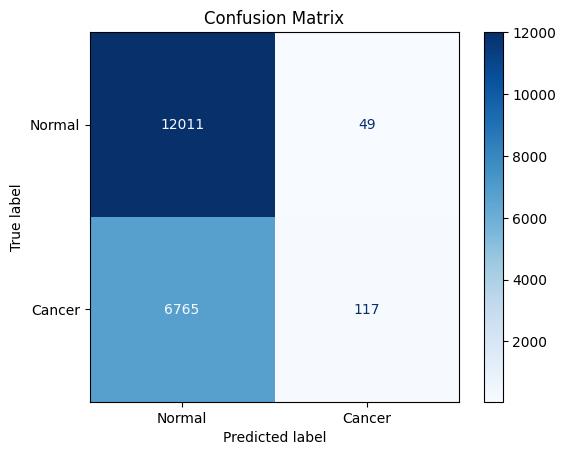

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import cv2
import os
from pathlib import Path
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ✅ 1. Define Dataset class
class PancreaticCancerDataset(Dataset):
    def __init__(self, ct_dir, mask_dir, transform=None):
        self.ct_dir = Path(ct_dir)
        self.mask_dir = Path(mask_dir)
        self.ct_images = sorted(self.ct_dir.rglob('*.png'))
        self.masks = sorted(self.mask_dir.rglob('*.png'))
        self.transform = transform

        if len(self.ct_images) != len(self.masks):
            min_len = min(len(self.ct_images), len(self.masks))
            self.ct_images = self.ct_images[:min_len]
            self.masks = self.masks[:min_len]

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        ct_image = cv2.imread(str(self.ct_images[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(self.masks[idx]), cv2.IMREAD_GRAYSCALE)

        ct_image = ct_image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        if self.transform:
            ct_image = Image.fromarray(ct_image)
            ct_image = self.transform(ct_image)

        label = 1 if np.sum(mask) > 0 else 0

        return ct_image, torch.tensor(label, dtype=torch.long)

# ✅ 2. Define DCNN Feature Extractor
class DCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(DCNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (B, 64, 1, 1)
        )

    def forward(self, x):
        return self.features(x)

# ✅ 3. Transformations for Input Data
transform_class = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
])

# ✅ 4. Load dataset and initialize dataloader
ct_dir = 'C:/preprocessed_pngs'
mask_dir = 'C:/preprocessed_masks'

cls_dataset = PancreaticCancerDataset(ct_dir, mask_dir, transform=transform_class)
cls_loader = DataLoader(cls_dataset, batch_size=4, shuffle=True)

# ✅ 5. Extract Features from Trained DCNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dcnn_model = DCNNFeatureExtractor().to(device)
dcnn_model.eval()

features, labels = [], []

with torch.no_grad():
    for imgs, lbls in cls_loader:
        imgs = imgs.to(device)
        feats = dcnn_model(imgs).view(imgs.size(0), -1)  # Flatten to (B, 64)
        features.append(feats.cpu().numpy())
        labels.append(lbls.numpy())

X = np.concatenate(features)
y = np.concatenate(labels)

print("✅ Feature extraction complete.")
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

# ✅ 6. Train DBN (RBM + Logistic Regression)
rbm = BernoulliRBM(n_components=128, learning_rate=0.06, n_iter=10, random_state=42)
logistic = LogisticRegression(max_iter=1000, solver='lbfgs')
dbn_model = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])
dbn_model.fit(X, y)

print("✅ DBN training complete.")

# ✅ 7. Evaluate Classifier
y_pred = dbn_model.predict(X)
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['Normal', 'Cancer']))

# ✅ 8. Confusion Matrix Visualization
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



✅ Dataset split: 15153 for training, 3789 for validation
✅ Feature extraction for train/val done.
Train Features: (15153, 64), Train Labels: (15153,)
Val Features: (3789, 64), Val Labels: (3789,)
✅ DBN training complete on training set.
📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      1.00      0.79      2456
      Cancer       0.65      0.01      0.02      1333

    accuracy                           0.65      3789
   macro avg       0.65      0.50      0.40      3789
weighted avg       0.65      0.65      0.52      3789



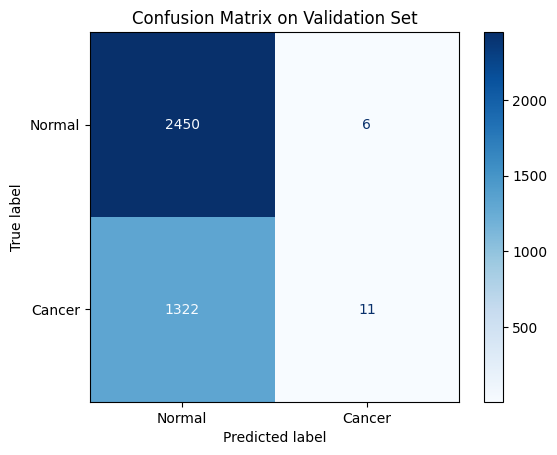

In [80]:
# ✅ 9. Split Dataset into Train and Validation Sets
from torch.utils.data import random_split

train_size = int(0.8 * len(cls_dataset))
val_size = len(cls_dataset) - train_size
train_dataset, val_dataset = random_split(cls_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"✅ Dataset split: {train_size} for training, {val_size} for validation")

# ✅ 10. Extract Features Separately from Train and Validation Sets
def extract_features(dataloader, model):
    feats, lbls = [], []
    model.eval()
    with torch.no_grad():
        for imgs, labels_batch in dataloader:
            imgs = imgs.to(device)
            out = model(imgs).view(imgs.size(0), -1)  # Flatten to (B, 64)
            feats.append(out.cpu().numpy())
            lbls.append(labels_batch.numpy())
    return np.concatenate(feats), np.concatenate(lbls)

X_train, y_train = extract_features(train_loader, dcnn_model)
X_val, y_val = extract_features(val_loader, dcnn_model)

print("✅ Feature extraction for train/val done.")
print(f"Train Features: {X_train.shape}, Train Labels: {y_train.shape}")
print(f"Val Features: {X_val.shape}, Val Labels: {y_val.shape}")

# ✅ 11. Train DBN on Train Set
rbm = BernoulliRBM(n_components=128, learning_rate=0.06, n_iter=10, random_state=42)
logistic = LogisticRegression(max_iter=1000, solver='lbfgs')
dbn_model = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])
dbn_model.fit(X_train, y_train)

print("✅ DBN training complete on training set.")

# ✅ 12. Evaluate on Validation Set
y_pred = dbn_model.predict(X_val)

print("📊 Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Normal', 'Cancer']))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Device setup (CPU only here)
device = torch.device("cpu")

# Check dataset
if 'cls_dataset' not in globals():
    raise NameError("cls_dataset not defined. Please load your dataset before training.")

# Split dataset (80/20)
train_size = int(0.8 * len(cls_dataset))
val_size = len(cls_dataset) - train_size
train_dataset, val_dataset = random_split(cls_dataset, [train_size, val_size])

# DataLoaders with fixed batch size
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
print(f"Train loader batches: {len(train_loader)}, Val loader batches: {len(val_loader)}")

def train_and_evaluate(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs=3, early_stop=True):
    model.to(device)
    best_acc = 0
    epochs_no_improve = 0
    patience = 2  # Stop if no improvement for 2 epochs
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        
        val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Early stopping check
        if early_stop:
            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    return best_acc, val_prec, val_rec, val_f1, val_auc

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc_score = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.0

    return accuracy, precision, recall, f1, auc_score

def tune_hyperparameters(model_class, train_loader, val_loader):
    learning_rates = [1e-3, 1e-4]
    optimizers = [optim.Adam]
    batch_sizes = [4]  # Fixed due to DataLoader constraints

    best_acc = 0
    best_params = None
    best_model = None

    for lr in learning_rates:
        for opt in optimizers:
            print(f"Trying lr={lr}, optimizer={opt.__name__}, batch_size={batch_sizes[0]}")
            model = model_class().to(device)
            optimizer = opt(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

            acc, prec, rec, f1, auc = train_and_evaluate(model, optimizer, criterion, scheduler, train_loader, val_loader)
            if acc > best_acc:
                best_acc = acc
                best_params = {'learning_rate': lr, 'optimizer': opt.__name__, 'batch_size': batch_sizes[0]}
                best_model = model

    print(f"Best params: {best_params}, Best accuracy: {best_acc:.2f}%")
    return best_model, best_params, best_acc

# Example usage (make sure you have dcnn_model class defined):
# best_model, best_params, best_acc = tune_hyperparameters(DCNNClassifier, train_loader, val_loader)


Train size: 15153, Val size: 3789
Train loader batches: 3789, Val loader batches: 948


In [85]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Train loader batch size: {train_loader.batch_size}")
print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batch size: {val_loader.batch_size}")
print(f"Val loader batches: {len(val_loader)}")


Train dataset size: 15153
Validation dataset size: 3789
Train loader batch size: 4
Train loader batches: 3789
Val loader batch size: 4
Val loader batches: 948


In [88]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def tune_dbn_hyperparameters(X_train, y_train, X_val, y_val):
    # Define DBN pipeline (RBM + Logistic Regression)
    rbm = BernoulliRBM(random_state=42, verbose=True)
    logistic = LogisticRegression(max_iter=1000, solver='lbfgs')
    dbn_pipeline = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

    # Hyperparameter grid for tuning
    param_grid = {
        'rbm__n_components': [64, 128],
        'rbm__learning_rate': [0.05, 0.1],
        'logistic__C': [0.1, 1.0, 10.0]
    }

    # Grid search with 3-fold CV
    grid_search = GridSearchCV(dbn_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predict on validation set
    y_pred = best_model.predict(X_val)

    # Compute metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    
    # For AUC, handle binary or multiclass
    try:
        if len(np.unique(y_val)) == 2:  # Binary
            y_prob = best_model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_prob)
        else:
            auc = roc_auc_score(y_val, best_model.predict_proba(X_val), multi_class='ovr')
    except Exception:
        auc = None  # If unable to calculate AUC

    return best_model, best_params, accuracy, precision, recall, f1, auc

# Example usage:
# X_train_dbn, y_train_dbn, X_val_dbn, y_val_dbn = your feature arrays for DBN training/validation
# best_dbn_model, best_dbn_params, accuracy, precision, recall, f1, auc = tune_dbn_hyperparameters(X_train_dbn, y_train_dbn, X_val_dbn, y_val_dbn)

# print("Best DBN params:", best_dbn_params)
# print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc}")


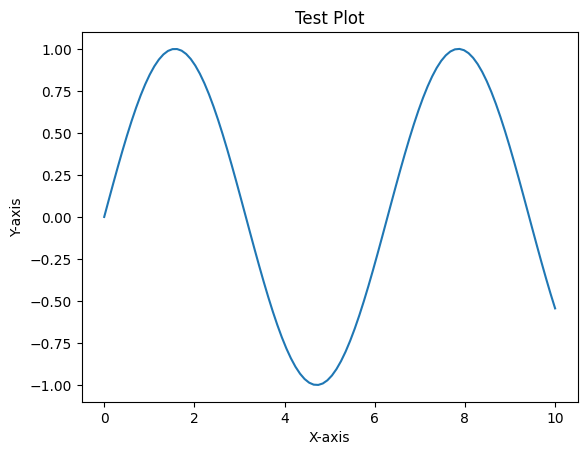

In [93]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title("Test Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [95]:
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid

def show_sample_images(dataset, num_images=12):
    fig = plt.figure(figsize=(10, 6))
    indices = random.sample(range(len(dataset)), num_images)
    images = [dataset[i][0] for i in indices]
    labels = [dataset[i][1] for i in indices]
    grid = make_grid(images, nrow=6, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Sample CT Scan Slices")
    plt.axis("off")
    plt.show()


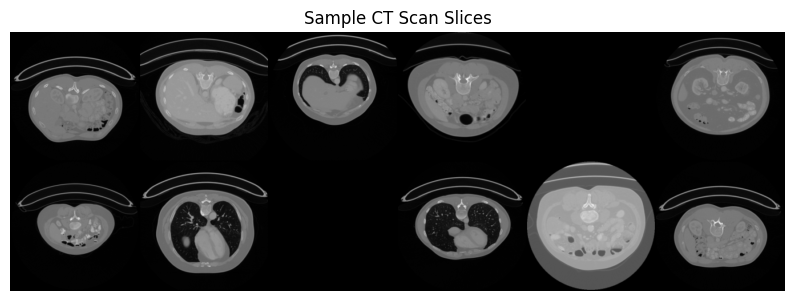

In [96]:
show_sample_images(train_dataset)


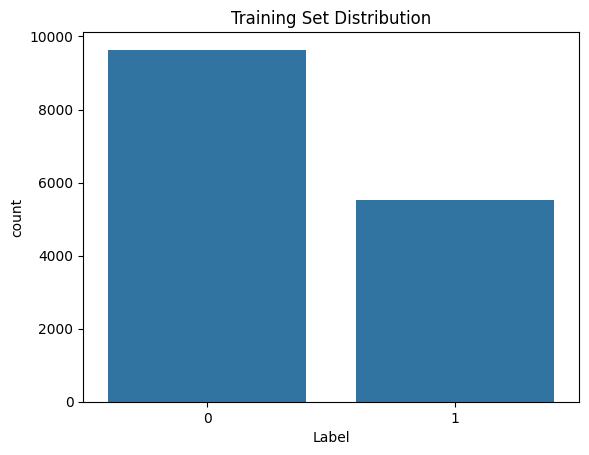

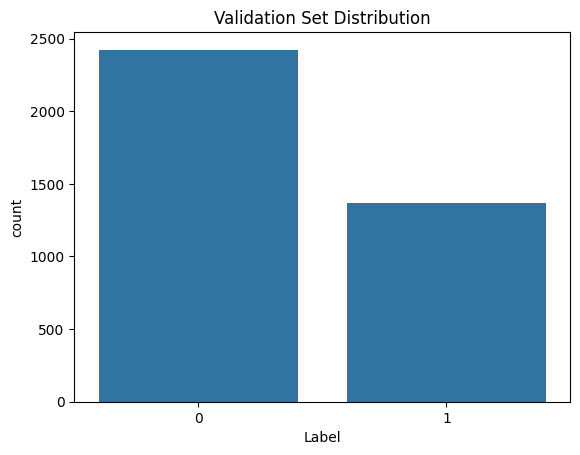

In [97]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(dataset, title="Class Distribution"):
    labels = [label for _, label in dataset]
    df = pd.DataFrame(labels, columns=["Label"])
    sns.countplot(data=df, x="Label")
    plt.title(title)
    plt.show()

plot_class_distribution(train_dataset, "Training Set Distribution")
plot_class_distribution(val_dataset, "Validation Set Distribution")


Detected 226 outliers.


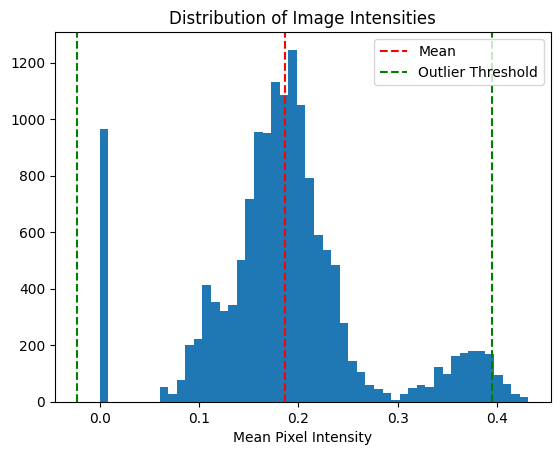

In [98]:
import numpy as np

def detect_outliers(dataset, threshold=2.5):
    means = [img.mean().item() for img, _ in dataset]
    mean_val = np.mean(means)
    std_val = np.std(means)
    outliers = [(i, m) for i, m in enumerate(means) if abs(m - mean_val) > threshold * std_val]
    
    print(f"Detected {len(outliers)} outliers.")
    plt.hist(means, bins=50)
    plt.axvline(mean_val, color='r', linestyle='--', label='Mean')
    plt.axvline(mean_val + threshold*std_val, color='g', linestyle='--', label='Outlier Threshold')
    plt.axvline(mean_val - threshold*std_val, color='g', linestyle='--')
    plt.title("Distribution of Image Intensities")
    plt.xlabel("Mean Pixel Intensity")
    plt.legend()
    plt.show()

detect_outliers(train_dataset)


In [99]:
class SimpleDCNN(nn.Module):
    def __init__(self):
        super(SimpleDCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (batch, 64, 1, 1)
        )

        self.classifier = nn.Linear(64, 2)  # Binary classification

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [100]:
model = SimpleDCNN().to(device)  # <-- this defines the model
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleDCNN().to(device)  # Define model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [102]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [105]:
%matplotlib inline

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Ensure matplotlib works in Jupyter/Colab
%matplotlib inline  

# Assuming you already have your model, train_loader, val_loader, and device

train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 10  # Change as needed
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_accs[-1]:.4f}")


Epoch [1/10], Train Loss: 0.6302, Val Loss: 0.6177, Train Acc: 0.6341, Val Acc: 0.6390
Epoch [2/10], Train Loss: 0.5758, Val Loss: 0.5490, Train Acc: 0.6660, Val Acc: 0.6735
Epoch [3/10], Train Loss: 0.5330, Val Loss: 0.5046, Train Acc: 0.7032, Val Acc: 0.7234
Epoch [4/10], Train Loss: 0.4938, Val Loss: 0.4892, Train Acc: 0.7341, Val Acc: 0.7224
Epoch [5/10], Train Loss: 0.4661, Val Loss: 0.4740, Train Acc: 0.7534, Val Acc: 0.7464
Epoch [6/10], Train Loss: 0.4428, Val Loss: 0.4319, Train Acc: 0.7683, Val Acc: 0.7933
Epoch [7/10], Train Loss: 0.4215, Val Loss: 0.4302, Train Acc: 0.7890, Val Acc: 0.7643
Epoch [8/10], Train Loss: 0.4044, Val Loss: 0.4031, Train Acc: 0.8009, Val Acc: 0.8076
Epoch [9/10], Train Loss: 0.3941, Val Loss: 0.3965, Train Acc: 0.8085, Val Acc: 0.8208
Epoch [10/10], Train Loss: 0.3785, Val Loss: 0.4331, Train Acc: 0.8164, Val Acc: 0.7601


In [107]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels))


In [108]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend()
    plt.show()


In [109]:
from sklearn.manifold import TSNE

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)
    df = pd.DataFrame(reduced, columns=['x', 'y'])
    df['label'] = labels
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10')
    plt.title("t-SNE Visualization of DCNN Features")
    plt.show()


In [110]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [111]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(val_losses, label="Val Loss", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [112]:
def plot_accuracy(train_accs, val_accs):
    plt.figure(figsize=(8, 5))
    plt.plot(train_accs, label="Train Accuracy", color='green')
    plt.plot(val_accs, label="Val Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [113]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels=["Normal", "Cancer"]):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


In [114]:
def plot_metrics(precision, recall, f1_score_val):
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = [precision, recall, f1_score_val]

    plt.figure(figsize=(6, 5))
    bars = plt.bar(metrics, values, color=['purple', 'teal', 'orange'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.1, yval + 0.01, f'{yval:.2f}')
    plt.ylim(0, 1.1)
    plt.title("Model Evaluation Metrics")
    plt.grid(True)
    plt.show()


In [115]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_probs):  # y_probs = predicted probabilities for class 1
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def generate_gradcam(model, image_tensor, target_class, final_conv_layer='features.6'):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    for name, module in model.named_modules():
        if name == final_conv_layer:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)

    output = model(image_tensor)
    model.zero_grad()

    class_loss = output[0, target_class]
    class_loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
    cam -= np.min(cam)
    cam /= np.max(cam)

    return cam

def show_gradcam_on_image(image_tensor, cam, alpha=0.4):
    image_np = image_tensor.cpu().numpy()[0][0]  # (1, 1, H, W)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    image_rgb = np.stack([image_np]*3, axis=2)
    overlay = heatmap * alpha + image_rgb * (1 - alpha)

    plt.figure(figsize=(8, 5))
    plt.imshow(np.uint8(255 * overlay))
    plt.title("Grad-CAM Heatmap Overlay")
    plt.axis("off")
    plt.show()


In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleDCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust depending on your input image size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # FC1 + ReLU
        x = self.fc2(x)                       # FC2
        return x


In [119]:
import numpy as np

def generate_gradcam(model, input_tensor, target_class, final_conv_layer_name='conv2'):
    gradients = []
    activations = []

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def save_activations(module, input, output):
        activations.append(output)

    # Register hooks on the final conv layer
    for name, module in model.named_modules():
        if name == final_conv_layer_name:
            module.register_forward_hook(save_activations)
            module.register_backward_hook(save_gradients)
            break
    else:
        raise ValueError(f"Layer {final_conv_layer_name} not found in the model.")

    model.zero_grad()
    output = model(input_tensor)
    class_loss = output[0, target_class]
    class_loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]      # (C, H, W)
    acts = activations[0].cpu().data.numpy()[0]         # (C, H, W)
    weights = np.mean(grads_val, axis=(1, 2))           # channel-wise mean of gradients

    cam = np.zeros(acts.shape[1:], dtype=np.float32)    # (H, W)
    for i, w in enumerate(weights):
        cam += w * acts[i, :, :]

    cam = np.maximum(cam, 0)                            # ReLU
    cam = cam - np.min(cam)
    cam = cam / (np.max(cam) + 1e-8)                    # Normalize between 0-1
    cam = np.uint8(cam * 255)
    return cam




In [120]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [122]:
import pydicom
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Update your DICOM path
data_dir = Path(r"C:\manifest-1599750808610")
dicom_files = list(data_dir.rglob("*.dcm"))

def load_patient_slices(dicom_files):
    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices = sorted(slices, key=lambda s: float(s.ImagePositionPatient[2]))
    return slices

def get_volume_from_slices(slices):
    images = np.stack([s.pixel_array.astype(np.float32) for s in slices])
    scaler = MinMaxScaler()
    flat = images.reshape(-1, 1)
    norm = scaler.fit_transform(flat).reshape(images.shape)
    return norm

# Now define sample_volume again
sample_slices = load_patient_slices(dicom_files[:100])
sample_volume = get_volume_from_slices(sample_slices)



In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SHAPCompatibleCNN(nn.Module):
    def __init__(self):
        super(SHAPCompatibleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # After two poolings (512 → 256 → 128), feature map is [32, 128, 128]
        # Flattened size is 32 * 128 * 128 = 524288
        self.fc1 = nn.Linear(32 * 128 * 128, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> (N, 16, 256, 256)
        x = self.pool2(F.relu(self.conv2(x)))  # -> (N, 32, 128, 128)
        x = x.view(x.size(0), -1)              # Flatten
        x = self.fc1(x)
        return x


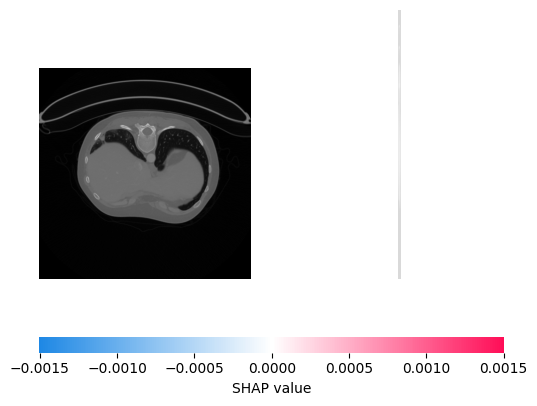

In [126]:
# Make sure model is in eval mode
model.eval()

# Choose the layer SHAP should hook into
target_layer = model.conv2

# Create the SHAP explainer
explainer = shap.GradientExplainer((model, target_layer), test_image)

# Compute SHAP values
shap_values = explainer.shap_values(test_image)

# Prepare image and SHAP values for visualization
test_image_vis = test_image.permute(0, 2, 3, 1).numpy()
shap_values_vis = [np.transpose(sv, (0, 2, 3, 1)) for sv in shap_values]

# Plot
shap.image_plot(shap_values_vis, test_image_vis)



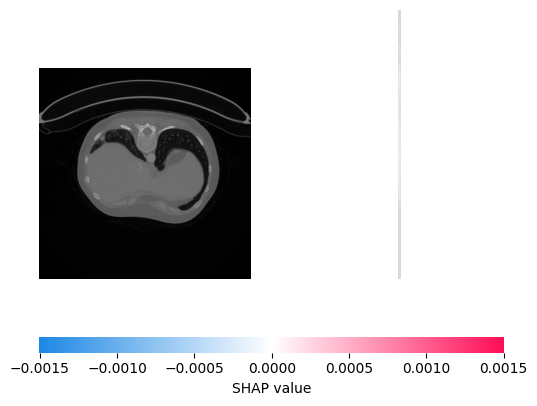

In [127]:
import shap
import torch
import numpy as np

# ✅ Step 1: Make sure your model is in evaluation mode
model.eval()

# ✅ Step 2: Choose the layer you want SHAP to explain (usually the last conv layer)
target_layer = model.conv2  # adjust if needed

# ✅ Step 3: Create the SHAP GradientExplainer
explainer = shap.GradientExplainer((model, target_layer), test_image)

# ✅ Step 4: Get SHAP values
shap_values = explainer.shap_values(test_image)

# ✅ Step 5: Format data for SHAP plotting
test_image_vis = test_image.permute(0, 2, 3, 1).numpy()  # (B, C, H, W) → (B, H, W, C)
shap_values_vis = [np.transpose(sv, (0, 2, 3, 1)) for sv in shap_values]

# ✅ Step 6: Plot SHAP explanation
shap.image_plot(shap_values_vis, test_image_vis)




In [128]:
class SimpleDCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleDCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # We'll define fc1 later, after computing the flatten size dynamically

        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Compute flatten size dynamically if fc1 not defined yet
        if self.fc1 is None:
            flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(flatten_size, 128).to(x.device)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [129]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path

# Define your mask PNG directory and device
mask_png_dir = Path(r'C:\preprocessed_masks')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform (resize, to tensor, normalize) if needed for your model
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Adjust to your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Example for single channel grayscale, adjust accordingly
])

# Load first 100 slices for background (assuming single channel grayscale masks)
background_imgs = []
png_files = sorted(mask_png_dir.glob('*.png'))[:100]

for file in png_files:
    img = Image.open(file).convert('L')  # Convert to grayscale
    img_tensor = transform(img)
    background_imgs.append(img_tensor)

background_tensor = torch.stack(background_imgs).to(device)  # Shape: (100, 1, H, W)


In [130]:
# Load the slice you want to explain
explain_img_path = png_files[0]  # example: first slice
img = Image.open(explain_img_path).convert('L')
img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: (1, 1, H, W)


In [131]:
from torchvision import transforms
from PIL import Image
import torch

# Define transform to resize, convert to tensor, repeat channels, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [1, H, W]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat single channel to 3 channels
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

background_imgs = []
input_imgs = []

# Assuming png_files is a list of your mask slice PNG file paths (from your previous code)
for file in png_files[:100]:  # Take first 100 images for background
    img = Image.open(file).convert('L')  # Load grayscale image
    img_tensor = transform(img)  # 3 x 224 x 224 tensor
    background_imgs.append(img_tensor)

background_tensor = torch.stack(background_imgs)  # Shape: (100, 3, 224, 224)

# For explaining one image
img = Image.open(png_files[0]).convert('L')
img_tensor = transform(img).unsqueeze(0)  # Shape: (1, 3, 224, 224)


In [132]:
# Check input size inside model before the linear layer
class YourModel(nn.Module):
    def forward(self, x):
        # ... after conv layers
        print(f"Shape before flatten: {x.shape}")  # Add this to debug
        x = x.view(x.size(0), -1)  # Flatten
        # then pass through linear layers
        return output


In [133]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [135]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Nice visual for Jupyter
df_report.style.background_gradient(cmap='YlGnBu').set_precision(2)


NameError: name 'y_test' is not defined